# Brian Kemp vs. Gavin Newsom Tweets

# Twitter API Pull

In [1]:
# for the twitter section
import tweepy
import os
import datetime
import re
from pprint import pprint

# for the lyrics scrape section
import requests
import time
from bs4 import BeautifulSoup
from collections import defaultdict, Counter

import os
import re
import emoji
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation

sw = stopwords.words("english")

#!pip install sklearn
#!pip install xgboost
#!pip install apikeys
#!pip install "apikey>=0.2.1"

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import apikey
from sklearn.decomposition import LatentDirichletAllocation
#!pip install pyLDAvis
from sklearn.decomposition import TruncatedSVD
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import string
from string import punctuation
import warnings
warnings.filterwarnings('ignore')

In [2]:
api_key='LUKbDXuSS6Z8tZoYvHtyS0OPk'
api_key_secret= 'dS9w5HSHhAAgEHrJPmnIiizEytWiGYITnxJkx1BeGfYJdeDyx1'
access_token= '1524139829268664321-7ftbINxgsCgcYUANOQJHDi4LzFLaQb'
access_token_secret= 'aZJ2tRZuc0RU4qUeCGEMkEty0GGoRCSeUSqMJY8H9Tp1e'

auth = tweepy.AppAuthHandler(api_key, api_key_secret)
api = tweepy.API(auth,wait_on_rate_limit = True)

In [3]:
pwd

'/Users/linanguyen/ADS 509 '

We need bring in our API keys. Since API keys should be kept secret, we'll keep them in a file called `api_keys.py`. This file should be stored in the directory where you store this notebook. The example file is provided for you on Blackboard. The example has API keys that are _not_ functional, so you'll need to get Twitter credentials and replace the placeholder keys. 

In [4]:
auth = tweepy.AppAuthHandler(api_key, api_key_secret)
api = tweepy.API(auth,wait_on_rate_limit = True)

In [5]:
tweet_data = {}

In [6]:
tweets = api.user_timeline(screen_name="briankempga", count=200, tweet_mode='extended')
all_tweets = []
all_tweets.extend(tweets)
oldest_id = tweets[-1].id
while True:
    tweets = api.user_timeline(screen_name="briankempga", count=200,
     max_id = oldest_id - 1,
     tweet_mode='extended')
    if len(tweets) == 0:
        break
    oldest_id = tweets[-1].id
    all_tweets.extend(tweets)
tweet_data["briankempga"] = all_tweets

In [7]:
tweets = api.user_timeline(screen_name="gavinnewsom", count=200, tweet_mode='extended')
all_tweets = []
all_tweets.extend(tweets)
oldest_id = tweets[-1].id
while True:
    tweets = api.user_timeline(screen_name="gavinnewsom", count=200,
     max_id = oldest_id - 1,
     tweet_mode='extended')
    if len(tweets) == 0:
        break
    oldest_id = tweets[-1].id
    all_tweets.extend(tweets)
tweet_data["gavinnewsom"] = all_tweets

In [8]:
res = []
for key, val in tweet_data.items():
    for item in val:
        res.append([key, item.full_text])
df = pd.DataFrame(res, columns=['id', 'text'])

First we extract the last 3000 tweets of two governers. Then we use a classification model to predict the owner of tweet from the tweet by using NLP and modeling

In [9]:
df.head()

,id,text
0,briankempga,RT @GOPGovs: Governor Brian Kemp supports law ...
1,briankempga,"ICYMI: In her own words, Stacey Abrams is a ""Y..."
2,briankempga,"For years, Stacey Abrams has been aligned with..."
3,briankempga,We had a great crowd at our lunch in Winder to...
4,briankempga,RT @GovKemp: https://t.co/YMNGbJKgQq


In [10]:
def clean_text(txt):
    if type(txt) != str:
        return ""
    txt = txt.lower()
    txt = re.sub('@[A-Za-z0-9_]+', '', txt)
    txt = re.sub('#[A-Za-z0-9_]+', '', txt)
    txt = re.sub(r'http\S+', '', txt)
    txt = txt.replace('\n', ' ')
    txt = re.sub('\s+', ' ', txt)
    txt = re.sub('[^a-z\s]','', txt)
    return txt

In [11]:
df['clean_text'] = df['text'].apply(clean_text)

In [12]:
df.head()

,id,text,clean_text
0,briankempga,RT @GOPGovs: Governor Brian Kemp supports law ...,rt governor brian kemp supports law and order...
1,briankempga,"ICYMI: In her own words, Stacey Abrams is a ""Y...",icymi in her own words stacey abrams is a yes ...
2,briankempga,"For years, Stacey Abrams has been aligned with...",for years stacey abrams has been aligned with ...
3,briankempga,We had a great crowd at our lunch in Winder to...,we had a great crowd at our lunch in winder to...
4,briankempga,RT @GovKemp: https://t.co/YMNGbJKgQq,rt


In [13]:
df['id'].value_counts()

gavinnewsom    3249
briankempga    3247
Name: id, dtype: int64

In [14]:
train, test = train_test_split(df[['id', 'clean_text']], test_size=0.3,shuffle=True, random_state=123)
train.shape, test.shape

((4547, 2), (1949, 2))

In [15]:
# remove the word which can leak some information about the tweet owner
mystopword = ENGLISH_STOP_WORDS.union(['ca', 'georgians','california', 'georgia', 'rt', 'ga'])

In [16]:
vec = TfidfVectorizer(stop_words=mystopword)
vec.fit(train['clean_text'])
X_train = vec.transform(train['clean_text'])
y_train = train['id']
X_test = vec.transform(test['clean_text'])
y_test = test['id']
X_train.shape

(4547, 7740)

### Random Forest Model

In [17]:
rf = RandomForestClassifier(max_depth=8)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

 briankempga       0.88      0.76      0.81       979
 gavinnewsom       0.78      0.90      0.84       970

    accuracy                           0.83      1949
   macro avg       0.83      0.83      0.83      1949
weighted avg       0.83      0.83      0.83      1949



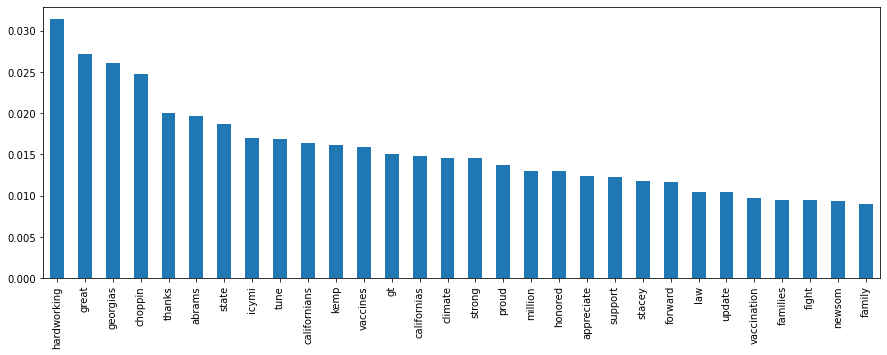

In [18]:
pd.Series(rf.feature_importances_, index=vec.get_feature_names()).\
    sort_values(ascending=False).head(30).plot(kind='bar', figsize=(15,5));

### XGB

In [19]:
xgb = XGBClassifier(max_depth=12, n_estimators=200)
xgb.fit(X_train, 1*(y_train == 'briankempga'))
y_pred = xgb.predict(X_test)
y_pred = ['gavinnewsom' if x == 0 else 'briankempga' for x in y_pred]
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

 briankempga       0.86      0.84      0.85       979
 gavinnewsom       0.84      0.86      0.85       970

    accuracy                           0.85      1949
   macro avg       0.85      0.85      0.85      1949
weighted avg       0.85      0.85      0.85      1949



### Logistic Regression 

In [20]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [21]:
from sklearn.metrics import accuracy_score
y_pred = lr.predict(X_test)
print('Accuracy Score - ', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy Score -  0.8902001026167266
              precision    recall  f1-score   support

 briankempga       0.90      0.88      0.89       979
 gavinnewsom       0.88      0.91      0.89       970

    accuracy                           0.89      1949
   macro avg       0.89      0.89      0.89      1949
weighted avg       0.89      0.89      0.89      1949



### Naive Bayes Model

In [22]:
# Vectorize text reviews to numbers
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()

nb.fit(X_train.todense(), y_train)

GaussianNB()

In [23]:
y_pred = nb.predict(X_test.todense())
print('Accuracy Score - ', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy Score -  0.7788609543355567
              precision    recall  f1-score   support

 briankempga       0.73      0.88      0.80       979
 gavinnewsom       0.85      0.68      0.75       970

    accuracy                           0.78      1949
   macro avg       0.79      0.78      0.78      1949
weighted avg       0.79      0.78      0.78      1949



### Linear SVC Model

In [24]:
# HyperTuning Parameters with Validation Set
from sklearn.svm import LinearSVC
lsvc = LinearSVC(verbose=0)

In [25]:
lsvc.fit(X_train, y_train)

LinearSVC()

In [26]:
y_pred = lsvc.predict(X_test)
print('Accuracy Score - ', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy Score -  0.8907131862493587
              precision    recall  f1-score   support

 briankempga       0.90      0.89      0.89       979
 gavinnewsom       0.89      0.90      0.89       970

    accuracy                           0.89      1949
   macro avg       0.89      0.89      0.89      1949
weighted avg       0.89      0.89      0.89      1949



### Support Vector Machines 

In [27]:
from sklearn import svm
svm = svm.SVC(kernel = 'linear')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print('Accuracy Score -', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy Score - 0.8953309389430477
              precision    recall  f1-score   support

 briankempga       0.91      0.88      0.89       979
 gavinnewsom       0.89      0.91      0.90       970

    accuracy                           0.90      1949
   macro avg       0.90      0.90      0.90      1949
weighted avg       0.90      0.90      0.90      1949



### K Nearest Neighbors

In [28]:
from sklearn.neighbors import KNeighborsClassifier
knn_r_acc = []
for i in range(1,17,1):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    test_score = knn.score(X_test, y_test)
    train_score = knn.score(X_train, y_train)
    knn_r_acc.append((i, test_score ,train_score))
df = pd.DataFrame(knn_r_acc, columns=['K','Test Score','Train Score'])
print(df)

     K  Test Score  Train Score
0    1    0.583376     0.996041
1    2    0.585428     0.991203
2    3    0.539764     0.585661
3    4    0.565418     0.745547
4    5    0.542329     0.621729
5    6    0.552591     0.652078
6    7    0.524885     0.574225
7    8    0.537199     0.593798
8    9    0.520780     0.545854
9   10    0.523858     0.560589
10  11    0.515136     0.528700
11  12    0.516162     0.535518
12  13    0.511544     0.519243
13  14    0.512057     0.521883
14  15    0.508466     0.513086
15  16    0.508466     0.515505


In [29]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print('Accuracy Score -', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy Score - 0.5833760903027193
              precision    recall  f1-score   support

 briankempga       0.90      0.19      0.32       979
 gavinnewsom       0.55      0.98      0.70       970

    accuracy                           0.58      1949
   macro avg       0.72      0.59      0.51      1949
weighted avg       0.73      0.58      0.51      1949



### Topic Modeling

### LDA 

In [30]:
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))


In [31]:


tweet_data = {}
tweets = api.user_timeline(screen_name="briankempga", count=200, tweet_mode='extended')
all_tweets = []
all_tweets.extend(tweets)
oldest_id = tweets[-1].id
while True:
    tweets = api.user_timeline(screen_name="briankempga", count=200,
     max_id = oldest_id - 1,
     tweet_mode='extended')
    if len(tweets) == 0:
        break
    oldest_id = tweets[-1].id
    all_tweets.extend(tweets)
tweet_data["briankempga"] = all_tweets

res = []
for key, val in tweet_data.items():
    for item in val:
        res.append([key, item.full_text])
df = pd.DataFrame(res, columns=['id', 'text'])





In [32]:
def clean_text(txt):
    if type(txt) != str:
        return ""
    txt = txt.lower()
    txt = re.sub('@[A-Za-z0-9_]+', '', txt)
    txt = re.sub('#[A-Za-z0-9_]+', '', txt)
    txt = re.sub(r'http\S+', '', txt)
    txt = txt.replace('\n', ' ')
    txt = re.sub('\s+', ' ', txt)
    txt = re.sub('[^a-z\s]','', txt)
    return txt

df['clean_text'] = df['text'].apply(clean_text)

# remove the word which can leak some information about the tweet owner
mystopword = ENGLISH_STOP_WORDS.union(['ca', 'georgians','california', 'georgia', 'rt', 'ga'])
vec = TfidfVectorizer(stop_words=mystopword)
vec.fit(df['clean_text'])
tfidf_vals = vec.transform(df['clean_text'])

In [33]:
lda_text_model = LatentDirichletAllocation(n_components=2, random_state=123)
lda_top = lda_text_model.fit_transform(tfidf_vals)

In [34]:
display_topics(lda_text_model, vec.get_feature_names())


Topic 00
  state (0.60)
  amp (0.58)
  choppin (0.42)
  proud (0.37)
  work (0.35)

Topic 01
  great (0.71)
  vote (0.66)
  kemp (0.51)
  choppin (0.45)
  lets (0.43)


In [35]:
df['topic'] = lda_top.argmax(1)
pd.crosstab(df['topic'], df['id'])

id,briankempga
topic,
0,1741
1,1506


In [36]:
lda_display = pyLDAvis.sklearn.prepare(lda_text_model, tfidf_vals, vec, sort_topics=False)
pyLDAvis.display(lda_display)

### LSA

In [37]:
svd_text_model = TruncatedSVD(n_components = 5, random_state=42)
W_svd_text_matrix = svd_text_model.fit_transform(tfidf_vals)
H_svd_text_matrix = svd_text_model.components_

In [38]:
# call display_topics on your model
display_topics(svd_text_model, vec.get_feature_names())


Topic 00
  choppin (1.70)
  great (0.98)
  state (0.98)
  support (0.84)
  vote (0.81)

Topic 01
  choppin (6.83)
  lets (1.61)
  thanks (0.85)
  dawgs (0.61)
  wood (0.59)

Topic 02
  vote (13.45)
  kemp (12.63)
  icymi (6.69)
  governor (6.65)
  brian (5.89)

Topic 03
  support (6.62)
  great (5.59)
  thanks (5.23)
  strong (5.09)
  appreciate (3.24)

Topic 04
  vote (82.73)
  lets (44.08)
  amp (28.84)
  election (25.10)
  early (23.30)


### Non-Negative Matrix Factorization Model

In [39]:

nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_vals)
H_text_matrix = nmf_text_model.components_

warnings.filterwarnings("ignore", category= FutureWarning)

In [40]:
display_topics(nmf_text_model, vec.get_feature_names())


Topic 00
  state (1.70)
  amp (1.49)
  fight (0.77)
  safe (0.72)
  hardworking (0.64)

Topic 01
  choppin (29.23)
  lets (6.53)
  dawgs (2.90)
  wood (2.65)
  congratulations (2.07)

Topic 02
  vote (7.02)
  lets (2.34)
  early (2.25)
  governor (2.15)
  election (2.14)

Topic 03
  support (4.21)
  great (3.93)
  thanks (3.41)
  strong (3.14)
  appreciate (2.10)

Topic 04
  kemp (5.45)
  icymi (5.06)
  gt (3.36)
  brian (3.16)
  gtgt (2.59)
